<center><h1>Compact Schemes
</h1></center>

<center>Marin Lauber, 2019</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    plt.style.use("jupyter")
except OSError:
    print("Delaut syle in use")

### Compact Schemes

On uniform grid, different types of schemes can be derived. Using polynomila fitting and the value of the derivative at neighbouring points, compact schemes can be derived. The main advantage of such schemes is the small width of the stencil compared to starndard central-difference schemes (central difference schemes have stencils whose width is half of the order of the leading truncation error term, see [here](https://en.wikipedia.org/wiki/Finite_difference_coefficient) and [here](https://www.sciencedirect.com/science/article/pii/S0045793012000138) for examples).

Compact and Pade schemes have the form

\begin{equation}
    \beta f_{i+2}' + \alpha f_{i+1}' + f_{i}' + \alpha f_{i-1}' +\beta f_{i-2}'=   a\frac{f_{i+1} - f_{i-1}}{2 \Delta x} + b\frac{f_{i+2} - f_{i-2}}{4 \Delta x} + c\frac{f_{i+3} - f_{i-3}}{6\Delta x}
\end{equation}

where the different coefficients are given by, depending on the order required (taken from Ferziger and Peric's great [book](http://www.cfd-peric.de)). You can also build them for [high-order derivatives](https://www.sciencedirect.com/science/article/pii/002199919290324R)

| Scheme | Truncation error | $\alpha$ | $\beta$ | $a$ | $b$ | $c$ |
| - | - | - | - | - | - | - | 
| CDS-2 | $\frac{(\Delta x)^2}{3!}\frac{\partial^3 f}{\partial x^3}$ | 0 | 0 | $1$ | 0 | 0 | 
| CDS-4 | $\frac{13(\Delta x)^4}{3\cdot3!}\frac{\partial^5 f}{\partial x^5}$ | 0 | 0 | $\frac{4}{3}$ | $-\frac{1}{3}$ | 0 |
| PADE-4 | $\frac{(\Delta x)^4}{5!}\frac{\partial^5 f}{\partial x^5}$ | $\frac{1}{4}$ | 0 | $\frac{3}{2}$ |  0 | 0 |
| PADE-6 | $\frac{4(\Delta x)^6}{7!}\frac{\partial^7 f}{\partial x^7}$ | $\frac{1}{3}$ | 0 | $\frac{14}{9}$ | $\frac{1}{9}$ |  0 | 


Pade schemes result in a system of equations of the form

\begin{equation}
    \bf{Ax= b}, 
\end{equation}

where $\bf{x}$ is understood to be a vector of the derivative of the function at the discrete points and $\bf{A}$ is a sparse coefficient matrix, depending on the scheme used. It is the identity matrix for non-Pade-like schemes and is tri-diagonal, circulant for Pade schemes on periodic functions. In Pade-type schemes, finding the derivative requires solving the system of linear equations to find

\begin{equation}
    \bf{x = A^{-1} b}.
\end{equation}

For periodic functions, the matrix $\bf{A}$ is tri-diagonal circulant, this can be efficiently solved using fast Fourier transforms (FFT), using the nice properties of circulant matrix (circulant convolution theorem). Effectively, looking at the linear system $\bf{Ax= b}$ and assuming a Pade scheme, $\bf{A}$ has the form

\begin{equation}
\bf{A}=\begin{bmatrix}
1 & \alpha & & & & & \alpha \\
\alpha & 1 & \alpha & & & & \\
 & \alpha & 1 & \alpha & & & \\
 & & \alpha & 1 & \alpha & & \\
  & & & \alpha & 1 & \alpha & \\
 & & & & \alpha & 1 & \alpha \\
\alpha & & & & & \alpha & 1 \\
\end{bmatrix},
\end{equation}

with all empty entries beeing zero. The vector of unkown, $\bf{b}$, has the form

\begin{equation}
\bf{b}=\begin{Bmatrix}
f_{0}' & f_{1}' & f_{2}' & \cdots & f_{n-1}' & f_{n}'
\end{Bmatrix}^\top,
\end{equation}

thus, looking at the first two entry of this product we have

\begin{equation}
\begin{split}
    ({\bf Ax})_0 & = f_{0}' + \alpha f_{1}' + 0\cdot f_{2}' + \cdots + 0\cdot f_{n-1}' + \alpha f_{n}', \\
    ({\bf Ax})_1 & = \alpha f_{0}' + f_{1}' + \alpha f_{2}' + \cdots + 0\cdot f_{n-1}' + 0\cdot f_{n}',\\
\end{split}
\end{equation}

which is easily recognise when written as a sum

\begin{equation}
    ({\bf Ax})_k = \sum_{j=0}^{n} a_{j-k} x_{j} = {\bf a \star b}.
\end{equation}

This is a circular convolution between the first row of $\bf A$ and ${\bf x}$. To avoid issues, the index $j-k$ are understood to be periodic. This can be very efficiently evaluated in Fourier space using the convolution theorem

\begin{equation}
    {\bf a \star x} = \mathcal{F}^{-1}\left(\mathcal{F}(\bf{a}) \mathcal{F}(\bf{x})\right),
\end{equation}

where $\mathcal{F}$ is a forward FFT and $\bf{a}$ is the first row of $\bf{A}$. This is much faster than Gaussian elimination or LU decomposition. Applying this to our linear system, we get for the vector of unknow derivatives

\begin{equation}
    \bf{x} = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(\bf{b})}{\mathcal{F}(\bf{a})}\right).
\end{equation}

In this case we can also use the fact that our output must be real, and use the Hermitan symmetry properties of the fourier coefficients, this saves us some addtionnal computations and storage.

In [2]:
def Compact(f, dx, scheme="CDS-2", timeit=False):
    """
    Second, fourth- and sixth-order compact scheme for first derivative of periodic field a:
    
    alpha*f'(i+1) + f'(i) + alpha*f'(i-1) = a*(f(i+1) - f(i-1)) + b*(f(i+2)  f(i-2))
    
    For Pade schemes, this results in a circulant tridiagonal matrix system which can 
    be solved using properties of the convolution and FFTs.
    
    Paramaters:
        a     : array of float
                values of the fiels at the grid points the array is assumed periodic
                such that the periodic point is NOT included
        dx    : float
                grid spacing, must be constant
        scheme: character string
                desired scheme, default is CDS-2
    Output:
        diff : array of float
               first derivative of the field
    
    Example:
        x,dx=np.linspace(0,2*np.pi,1000,endpoint=False,retstep=True)
        f=np.cos(x)
        df=-np.sin(x)
        print(np.allclose(Compact(f,dx, "PADE-4"),df))
    """
    
    # standard parameters for CDS-2
    alpha = 0.
    a  = 1./(2.*dx)
    b = 0.
    
    # adjust params otherwise
    if scheme == "CDS-4":
        alpha = 0.
        a  = 2./(3.*dx)
        b = -1./(12.*dx)
    if scheme == "PADE-4":
        alpha = 0.25
        a  = 3./(4.*dx)
        b = 0.
    if scheme == "PADE-6":
        alpha = 1./3.
        a  = 14./(18.*dx)
        b = 1./(36.*dx)
    
    # temp array
    sol = np.empty_like(f)
    
    # compact scheme on interior points
    sol[2:-2] = a * (f[3:-1] - f[1:-3]) + b * (f[4:] - f[:-4])
    
    # boundary points
    sol[-2] = a * (f[-1] - f[-3]) + b * (f[0] - f[-4])
    sol[-1] = a * (f[ 0] - f[-2]) + b * (f[1] - f[-3])
    sol[ 0] = a * (f[ 1] - f[-1]) + b * (f[2] - f[-2])
    sol[ 1] = a * (f[ 2] - f[ 0]) + b * (f[3] - f[-1])
    
    # return
    if alpha == 0.:

        return sol

    else:
        # build first row of circulant Pade coefficients matrix
        A = np.hstack((1., alpha, [0.*j for j in range(len(f)-3)], alpha))

        # solve tri-diagonal system using FFTs and circulant matrix properties
        diff = np.fft.irfft(np.fft.rfft(sol)/np.fft.rfft(A))
        
    if timeit == True:
        
        import timeit
        from scipy import sparse
        
        %timeit np.fft.irfft(np.fft.rfft(sol)/np.fft.rfft(A))
        
        # build ugly matrix by hand
        A = sparse.diags([alpha,1,alpha],[-1,0,1],shape=(len(f),len(f))).toarray()
        A[ 0,-1] = alpha
        A[-1, 0] = alpha
        
        %timeit np.linalg.solve(A, sol)
   
    return diff

To test our implementation we use a know periodic function (and its derivative)

\begin{equation}
\begin{split}
    f & = \cos(x), \\
    f'& = -\sin(x). 
\end{split}
\end{equation}

This is discretized on a $2\pi$ grid, with $N=1000$ points.

In [3]:
x, dx= np.linspace(0, 2*np.pi, 1000, endpoint=False, retstep=True)
f = np.cos(x)
df = -np.sin(x)
for scheme in ["CDS-2","CDS-4","PADE-4","PADE-6"]:
    print(np.allclose(Compact(f, dx, scheme), df))

True
True
True
True


Using the `timeit=True` flag we can compare the convolution method against a standard `np.linalg.solve`, which uses a LU decomposition (packed in the LAPACK routine `_gesv`). We will use our previous function and dump the result to a dummy array.

In [4]:
_ = Compact(f, dx, "PADE-6", timeit=True)

130 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
35.7 ms ± 7.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The convolution-based method is roughly 350 times faster than the standard LU decomposition!

---

## Order or accuracy

The Gaussian profile with a mean $\nu$ and a variance $\sigma^2$ is defined as

\begin{equation}
    \mathcal{N}(x | \nu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}e^{\frac{-(x-\nu)^2}{2\sigma^2}}.
\end{equation}

In [5]:
def Gaussian(x, v=3., sigma=1.):
    return np.exp(-(x - v)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi)* sigma)

It's derivative can be computed analytically

\begin{equation}
    \frac{d}{dx}\mathcal{N}(x | \nu, \sigma^2) = \frac{-(x-\nu)^2}{\sigma^3\sqrt{2\pi}}e^{\frac{-(x-\nu)^2}{2\sigma^2}}.
\end{equation}

In [6]:
def GaussianDer(x, v=3., sigma=1.):
    return -(x - v) * np.exp(-(x - v)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma**3)

We can now use this to check the accuracy of our schemes

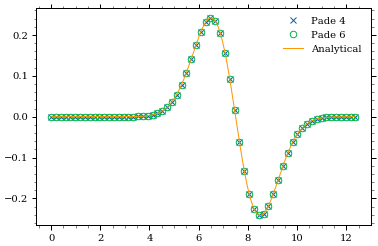

In [7]:
x, dx = np.linspace(0, 4*np.pi, 64, endpoint=False, retstep=True)
f = Gaussian(x,sigma=1.,v=7.5)
plt.plot(x, Compact(f, dx, "PADE-4"), 'x', markevery=1, label="Pade 4")
plt.plot(x, Compact(f, dx, "PADE-6"), 'o', mfc="None", markevery=1, label="Pade 6")
x_sol = np.linspace(np.min(x), np.max(x), 1000, endpoint=False)
plt.plot(x_sol, GaussianDer(x_sol, v=7.5, sigma=1.), label="Analytical")
plt.legend();

In [8]:
norm = np.ones((5, 4))
schemes = np.array(["CDS-2","CDS-4","PADE-4","PADE-6"])
resolutions = np.array([32,64,128,256])
for i, scheme in enumerate(schemes):
    for j, res in enumerate(resolutions):
        x, dx = np.linspace(0, 4*np.pi, res, endpoint=False, retstep=True)
        f = Gaussian(x, v=7.5, sigma=1.)
        norm[i, j] = np.max(np.abs(Compact(f, dx, scheme)-GaussianDer(x, v=7.5, sigma=1.)))

We look at the error of our method using the $L_\infty$ norm

$$
    L_\infty = \max{\vert u_h - u_e\vert}
$$

where $u_h$ is the discretized solution, and $u_e$ is the exact solution.

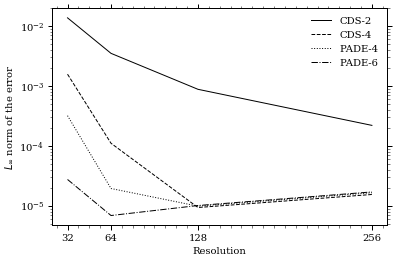

In [9]:
col = ['-', '--', ':', '-.']
for i, scheme in  enumerate(schemes):
    plt.semilogy(resolutions, norm[i,:], label=scheme, c='k', linestyle=col[i])
plt.xticks(resolutions)
plt.legend(); plt.xlabel("Resolution"); plt.ylabel(r"$L_{\infty}$ norm of the error")
plt.show()

---

## Spectral Equivalence

It is easy to show that the Fourier coefficients $\tilde{f}_l'$ associated with the Pade approximation presented earlier are linked to the Fourier coefficients

$$
    \tilde{f}_l = \frac{1}{n_x}\sum_{j=1}^{n_x}f_j e^{-ik_xx_j}, \quad \text{for} \; -n_x/2 < l <n_x/2-1,
$$

by the simple spectral relation

$$
    \tilde{f}'_l = ik_x'\tilde{f}_l,
$$

where $i$ is the imaginary number, and $k_x'$ is the modified wavenumber (for a spectral method those are the standard wavenumber). For compact schemes, the modified wavenumer are given by

$$
    k_x'\Delta x = \frac{a\sin(k_x\Delta x) + (b/2)\sin(2k_x\Delta x) +(c/3)\sin(3k\Delta x)}{1+2\alpha\cos(k_x\Delta x) + 2\beta\cos(2k_x\Delta x)}.
$$

In [10]:
def k_prime(kx, dx, alpha=1./3, beta=0., a=14./9, b=1./9, c=0.):
    return ((a * np.sin(kx*dx) + (.5*b)*np.sin(2*kx*dx) + (c/3*np.sin(3*kx*dx)))/
            (1 + 2*alpha*np.cos(kx*dx) + 2*beta*np.cos(2*kx*dx))) / dx

The modified wavenumber represents the eigenvalues of the discrete operator. In this case, high wavenumber modes are dampended.

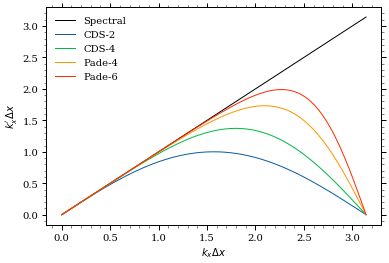

In [11]:
N = 256; L = 1; dx = L/N
kx = np.fft.rfftfreq(N, d=1./N) * 2*np.pi / L
coeffs = np.array([[0, 0, 1, 0, 0],
                   [0, 0, 4./3, -1./3, 0],
                   [1./4., 0., 3./2, 0, 0],
                   [1./3, 0., 14./9, 1./9, 0.]])
plt.plot(kx*dx, kx*dx, 'k')
for i in range(4):
    kx_p = k_prime(kx, dx, *coeffs[i,:])
    plt.plot(kx*dx, kx_p*dx)
plt.xlabel(r"$k_x\Delta x$"); plt.ylabel(r"$k_x'\Delta x$");
plt.legend(["Spectral","CDS-2","CDS-4","Pade-4","Pade-6"]);

This means that we can obtain a central difference scheme simply multiplying the corresponding fourier coefficients with the correct modified wavenumber for that scheme, without having to build a stencil, or invert a large matrix.

In [12]:
def spectral(a, dx):
    """
    Takes the first derivative of a discrete periodic field a
    using Fourier spectral colocation method
    
    """
    # length of array
    N = len(a)
    L = N * dx

    # wavenumber
    kx = np.fft.rfftfreq(N, d=1./N) * 2 * np.pi / L

    # transform, differentiate, transform back
    four = np.fft.irfft(1j* kx * np.fft.rfft(a))
    
    return four

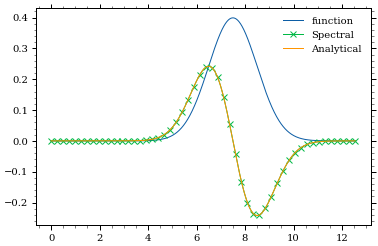

In [13]:
x, dx = np.linspace(0, 4*np.pi, 1024, endpoint=False, retstep=True)
f = Gaussian(x,sigma=1.,v=7.5)
plt.plot(x, f, label="function")
plt.plot(x, spectral(f, dx), '-x', markevery=20, label="Spectral")
x_sol = np.linspace(np.min(x), np.max(x), 1000, endpoint=False)
plt.plot(x_sol, GaussianDer(x_sol, v=7.5, sigma=1.), label="Analytical")
plt.legend();

In [14]:
def spectral_compact(f, dx):
    """
    Takes the first derivative of a discrete periodic field f
    using coompact scheme and modified wavenumber
    
    """
    # length of array
    N = len(f)
    L = N * dx

    # wavenumber
    kx = np.fft.rfftfreq(N, d=1./N) * 2*np.pi / L
    # modified wavenumber
    kx_p = k_prime(kx, dx)
    # transform, differentiate, transform back
    four = np.fft.irfft(1j* kx_p * np.fft.rfft(f))
    
    return four

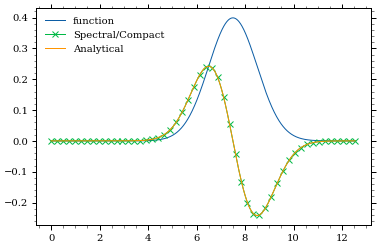

In [15]:
plt.plot(x, f, label="function")
plt.plot(x, spectral_compact(f, dx), '-x', markevery=20, label="Spectral/Compact")
x_sol = np.linspace(np.min(x), np.max(x), 1000, endpoint=False)
plt.plot(x_sol, GaussianDer(x_sol, v=7.5, sigma=1.), label="Analytical")
plt.legend();

These should be equivalent to the Pade approximation that we have computed earlier.

In [16]:
print("All close?", np.allclose(spectral_compact(f, dx), Compact(f, dx, "PADE-6")))
print("L-inf norm: %.4e" % np.max(np.abs(spectral_compact(f, dx) - Compact(f, dx, "PADE-6"))))

All close? True
L-inf norm: 8.9963e-15


How does that compare to the stencile-based compact scheme function?

In [17]:
%timeit Compact(f, dx, "PADE-6")
%timeit spectral_compact(f, dx)

423 µs ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
232 µs ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The spectral method is much faster! About three times. The other advantage is that is is very easily extended to higher-dimensions.

---

## Optimal coefficients

[Jae Wook Kim et el.](https://pdfs.semanticscholar.org/916c/3246fe4fd1c2a2e6dc387ce800f486df404d.pdf) derived coefficients for the compact schemes that maximise the resolution of each scheme by minimising the dispersive (phase) error of each scheme. It should be remembered that this does not change the truncation error of the scheme, only its dispersive errors.

Here most of the schemes are tri-diagonal, even at low truncation error.

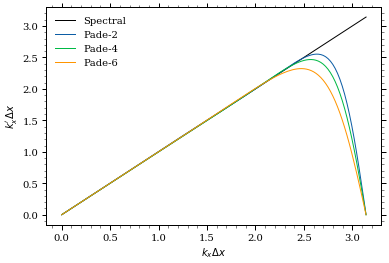

In [18]:
N = 256; L = 1; dx = L/N
kx = np.fft.rfftfreq(N, d=1./N) * 2*np.pi / L
coeffs = np.array([[0.450901855, 0., 1.545790417, 0.434249728, -0.078236437],
                   [0.435181352, 0., 1.551941906, 0.361328195, -0.042907397],
                   [0.408589269, 0., 1.568098212, 0.271657107, -0.022576781]])
plt.plot(kx*dx, kx*dx, 'k')
for i in range(coeffs.shape[0]):
    kx_p = k_prime(kx, dx, *coeffs[i,:])
    plt.plot(kx*dx, kx_p*dx)
plt.xlabel(r"$k_x\Delta x$"); plt.ylabel(r"$k_x'\Delta x$");
plt.legend(["Spectral","Pade-2","Pade-4","Pade-6"]);

---

## Multi-Dimension version

With little effort the previsou function can be extended to two and three dimensions. And we can still use the convolution theorem to solve the resulting tri-diagonal circulant system! (as loog as the field is prediodic)

We will test it on the [Taylor-Green vortex](https://en.wikipedia.org/wiki/Taylor%E2%80%93Green_vortex) (here we only use a single component and generate a 2D field)

$$
    u = \sin{(x)}\cos{(4y)}
$$

In [19]:
x, dx = np.linspace(0, 2*np.pi, 256, retstep=True, endpoint=False)
u = np.sin(x) * np.cos(4*x[:, np.newaxis])

In [20]:
def Compact2D(f, dx, scheme="CDS-2"):
    """
    Second, fourth- and sixth-order compact scheme for first derivative of periodic field a:
    
    alpha*f'(i+1) + f'(i) + alpha*f'(i-1) = a*(f(i+1) - f(i-1)) + b*(f(i+2)  f(i-2))
    
    For Pade schemes, this results in a circulant tridiagonal matrix system which can 
    be solved using properties of the convolution and FFTs.
    
    Paramaters:
        a     : array of float
                values of the fiels at the grid points the array is assumed periodic
                such that the periodic point is NOT included
        dx    : float
                grid spacing, must be constant
        scheme: character string
                desired scheme, default is CDS-2
    Output:
        diff : array of float
               first derivative of the field
    
    Example:
        x,dx=np.linspace(0,2*np.pi,1000,endpoint=False,retstep=True)
        f=np.cos(x)
        df=-np.sin(x)
        print(np.allclose(Compact(f,dx, "PADE-4"),df))
    """
    
    # standard parameters for CDS-2
    alpha = 0.; a  = 1./(2.*dx); b = 0.
    
    # adjust params otherwise
    if scheme == "CDS-4":
        alpha = 0.; a  = 2./(3.*dx); b = -1./(12.*dx)
    if scheme == "PADE-4":
        alpha = 0.25; a  = 3./(4.*dx); b = 0.
    if scheme == "PADE-6":
        alpha = 1./3.; a  = 14./(18.*dx); b = 1./(36.*dx)
    
    # temp array
    sol = np.empty_like(f)
    
    # compact scheme on interior points
    sol[:, 2:-2] = a * (f[:, 3:-1] - f[:, 1:-3]) + b * (f[:, 4:] - f[:, :-4])
    
    # boundary points
    sol[:, -2] = a * (f[:, -1] - f[:, -3]) + b * (f[: , 0] - f[:, -4])
    sol[:, -1] = a * (f[:,  0] - f[:, -2]) + b * (f[:,  1] - f[:, -3])
    sol[:,  0] = a * (f[:,  1] - f[:, -1]) + b * (f[:,  2] - f[:, -2])
    sol[:,  1] = a * (f[:,  2] - f[:,  0]) + b * (f[:,  3] - f[:, -1])
    
    # return
    if alpha == 0.:

        return sol

    else:
        # build first row of circulant Pade coefficients matrix
        A = np.hstack((1., alpha, [0.*j for j in range(len(f)-3)], alpha))

        # solve tri-diagonal system using FFTs and circulant matrix properties
        diff = np.fft.irfft2(np.fft.rfft2(sol)/np.fft.rfft(A))
   
    return diff

The exact solution of the gradients are
$$
\begin{split}
    \frac{\partial u}{\partial x} &= \cos{(x)} \cos{(4y)}\\
    \frac{\partial u}{\partial y} &= -\sin{(x)} 4\sin{(4y)}\\
\end{split}
$$
Again, we will use the $L_{\infty}$ norm of the error to check our implementation

In [21]:
dudx = Compact2D(u, dx, scheme="PADE-6")
print("Linf norm of the error for d/dx is %.3e" % np.max(np.abs(dudx-np.cos(x)*np.cos(4*x[:,np.newaxis]))))

Linf norm of the error for d/dx is 1.156e-13


In [22]:
dudy = Compact2D(u.T, dx, scheme="PADE-6").T
print("Linf norm of the error for d/dx is %.3e" % np.max(np.abs(dudy+np.sin(x)*4*np.sin(4*x[:,np.newaxis]))))

Linf norm of the error for d/dx is 1.707e-09


Here, we have lost accuracy while doing the transpose.